# CS/ECE/ISyE 524 - Spring 2017 - Homework 5 - Solutions
### Prepared by: Laurent Lessard

## 1. Enclosing circle

Given a set of points in the plane $x_i \in \mathbb{R}^2$, we would like to find the circle
with smallest possible area that contains all of the points. Explain how to model this as an optimization
problem. To test your model, generate a set of 50 random points using the code `X = 4+randn(2,50)`
(this generates a $2\times 50$ matrix $X$ whose columns are the $x_i$). Produce a plot of the randomly generated
points along with the enclosing circle of smallest area.

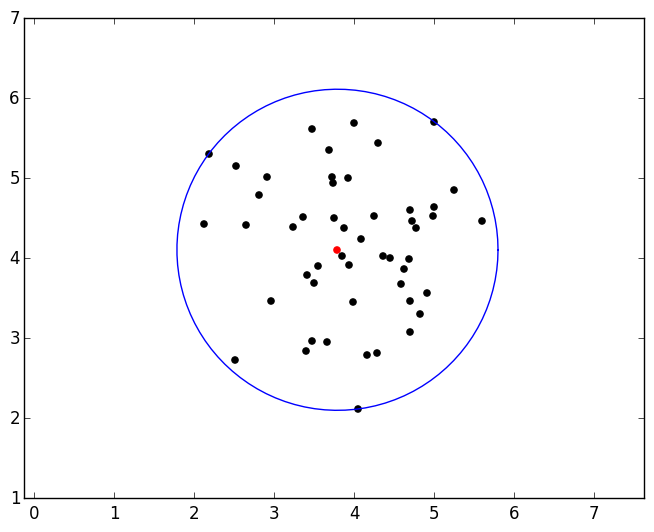

The center of the circle is (3.7887154172090876, 4.108380244950692). Radius is 2.0070299213237823


In [23]:
N = 50               # number of points
X = 4 + randn(2,N)   # generate random points

# plot 
t = linspace(0,2π,100)   # parameter that traverses the circle

# solve the problem --- this is an SOCP.
using JuMP,Gurobi

m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, xc[1:2]) # center of circle
@variable(m, r) # radius square

@constraint(m, constr[i in 1:N], norm(X[:,i] - xc) <= r) # every point is in the circle
@objective(m, Min, r)

solve(m);

# plot the points and the circle
c1 = getvalue(xc[1])
c2 = getvalue(xc[2])
ropt = getvalue(r)

println("The center of the circle is (",c1,", ", c2, "). Radius is ", ropt)

using PyPlot
t = linspace(0,2π,100)
axis("equal")
scatter(c1, c2, color = "red");
scatter( X[1,:], X[2,:], color = "black")
plot( c1 + ropt*cos(t), c2 + ropt*sin(t))
;

## 2. Quadratic form positivity

You're presented with the constraint:
\begin{equation}
2x^2 + 2y^2 + 9z^2 + 8xy -6xz - 6yz \le 1 \hspace{2cm} (1)
\end{equation}

**a)** It turns out the above constraint is _not_ convex. In other words, the set of $(x,y,z)$ satisfying the constraint (1) is not an ellipsoid. Explain why this is the case.

**b)** Show that the following QCQP is _unbounded_:
\begin{align*}
\text{maximize}\qquad& x^2 + y^2 + z^2 \\
\text{subject to}\qquad& (1)
\end{align*}
_Hint:_ this is not a convex QCQP because as seen above, (1) is not convex. Moreover, the objective is not convex because it involves _maximizing_ a positive definite quadratic. So do not attempt to solve this using JuMP! Instead, show how to construct a vector $(x,y,z)$ of arbitrarily large magnitude that satisfies (1).


**Solution to part a):** The constraint is an ellipsoid if and only if all eigenvalues of the associated symmetric matrix are nonnegative. We will verify that this is not the case by computing the eigenvalues directly. To do this, first we form the symmetric matrix by extracting the coefficients of the quadratic and then we find its eigenvalue decomposition:

In [32]:
A = [2 4 -3; 4 2 -3; -3 -3 9]
eigvals(A)

3-element Array{Float64,1}:
 -2.0
  3.0
 12.0

**Solution to part b)** To show that the optimization problem is unbounded, we will construct a feasible vector of arbitrarily large magnitude. There are many ways to do this; we'll follow the approach from class, where we start by constructing a vector $(x,y,z)$ such that the quadratic form is negative.

In [41]:
(Λ,V) = eig(A)

# verify that the eigenvalue decomposition is accurate. This should be zero:
println("This matrix should be zero:")
sleep(.1)
display(A - V*diagm(Λ)*V')

# new coordinates are [p;q;r] = V'*[x;y;z].
# this leads to the equivalent quadratic form: λ1*p^2 + λ2*q^2 + λ3*r^2.
# the first eigenvalue corresponds to λ1 = -2. So let's pick p=1, q=0, r=0.
# to invert this, we compute: [x;y;z] = V*[1;0;0]
println("The following (x,y,z) makes the quadratic form negative:")
sleep(.1)
xbad = V*[1;0;0]
display(xbad)

# let's verify that it actually makes the quadratic form negative. We can take any multiple of this,
# so let's use the simplest expression possible: x=1, y=-1, z=0
println("Value of quadratic form when (x,y,z) = (1,-1,0):")
sleep(.1)
x,y,z = 1,-1,0
display(2x^2 + 2y^2 + 9z^2 + 8x*y -6x*z - 6y*z)

This matrix should be zero:


3×3 Array{Float64,2}:
  1.33227e-15   1.77636e-15  -1.77636e-15
  1.77636e-15   8.88178e-16  -1.77636e-15
 -1.77636e-15  -1.77636e-15  -1.77636e-15

The following (x,y,z) makes the quadratic form negative:


3-element Array{Float64,1}:
  0.707107
 -0.707107
  0.0     

Value of quadratic form when (x,y,z) = (1,-1,0):


-4

Now we observe that if we choose $(x,y,z) = (t,-t,0)$, then the constraint looks like:
$$
-4t^2 \le 1
$$
which is satisfied for any $t$. Also, the objective function is:
$$
x^2+y^2+z^2 = 2t^2
$$
Therefore as we make $t$ larger, the points $(t,-t,0)$ are always feasible yet lead to an unbounded objective as $t\to\infty$.

## 3. Hovercraft rendezvous

Alice and Bob are cruising on Lake Mendota in their  hovercrafts. Each hovercraft has the following dynamics: 
$$
\text{Dynamics of each hovercraft:}\qquad
\begin{aligned}
x_{t+1} &= x_t + \tfrac{1}{3600} v_t \\
v_{t+1} &= v_t + u_t
\end{aligned}
$$
At time $t$ (in seconds), $x_t \in \mathbb{R}^2$ is the position (in miles), $v_t \in \mathbb{R}^2$ is the velocity (in miles per hour), and $u_t \in \mathbb{R}^2$ is the thrust in normalized units. At $t=1$, Alice has a speed of 20~mph going North, and Bob is located half a mile East of Alice, moving due East at 30~mph. Alice and Bob would like to rendezvous at $t=60$ seconds. The location at which they meet is not important, but the time is!

**a)** Find the sequence of thruster inputs for Alice ($u^A$) and Bob ($u^B$) that achieves a rendezvous at $t=60$ while minimizing the total energy used by both hovercraft:
$$
\text{total energy} = \sum_{t=1}^{60} \left\|u_t^A\right\|^2 + \sum_{t=1}^{60} \left\|u_t^B\right\|^2
$$
Plot the trajectories of each hovercraft to verify that they do indeed rendezvous.

**b)** In addition to arriving at the same place at the same time, Alice and Bob should also make sure their velocities match when they rendezvous. If not, they might crash into each other! Solve the rendezvous problem again with the additional velocity matching constraint and plot the resulting trajectories. Is the optimal rendezvous location different from the one found in the first part?

**c)** Alice and Bob forgot about one important detail. The hovercrafts each have a top speed of 35~mph. The solutions found in the previous parts are unacceptable because they require Alice to exceed the maximum allowable speed. First, verify that this is indeed the case. Second, explain how to alter your model to account for the speed limit. Finally, solve the rendezvous problem one last time with all the constraints in place and verify that your solution respects the speed limit.

In [69]:
#PART A: Meet somewhere and minimize energy

using JuMP, Gurobi

st = 60 # stop time point

m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, A_x[1:2, 1:st]) # position of Alice
@variable(m, A_v[1:2, 1:st]) # velocity
@variable(m, A_u[1:2, 1:st]) # thrust

@variable(m, B_x[1:2, 1:st]) # position of Bob
@variable(m, B_v[1:2, 1:st]) # velocity
@variable(m, B_u[1:2, 1:st]) # thrust

# initial
@constraint(m, A_x[:, 1] .== [0, 0])   # let's put A at the origin
@constraint(m, B_x[:, 1] .== [0.5, 0]) # B is half a mile east of A
@constraint(m, A_v[:, 1] .== [0, 20])  # A is moving North at 20 mph
@constraint(m, B_v[:, 1] .== [30, 0])  # B is moving East at 30 mph

# Dynamics
for i = 2:st
    @constraint(m, A_x[:, i] .== A_x[:, i-1] + A_v[:, i-1]/3600)
    @constraint(m, B_x[:, i] .== B_x[:, i-1] + B_v[:, i-1]/3600)
    @constraint(m, A_v[:, i] .== A_v[:, i-1] + A_u[:, i-1])
    @constraint(m, B_v[:, i] .== B_v[:, i-1] + B_u[:, i-1])
end

# meet at the given time.
@constraint(m, A_x[:, st] .== B_x[:, st])

@objective(m, Min, sum(A_u.^2) + sum(B_u.^2))

solve(m)

println("The minimum energy is ",getobjectivevalue(m))

The minimum energy is 105.9307047910204


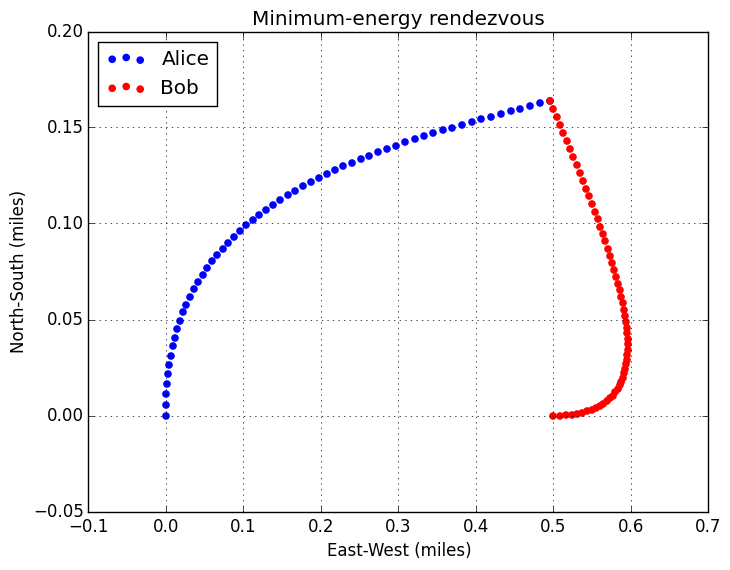

In [70]:
using PyPlot

scatter(getvalue(A_x[1,:]), getvalue(A_x[2,:]),color = "blue", label = "Alice")
scatter(getvalue(B_x[1,:]), getvalue(B_x[2,:]),color = "red", label = "Bob")
xlabel("East-West (miles)")
ylabel("North-South (miles)")
legend(loc = "upper left")
grid()
title("Minimum-energy rendezvous");

In [71]:
#PART B: Meet somewhere, match velocity, and minimize energy

# we can keep the same model as before. We only need to add one more constraint:
@constraint(m, A_v[:, st] .== B_v[:, st])   # extra constraint: match velocities!

solve(m)
println("The minimum energy is ",getobjectivevalue(m))

The minimum energy is 234.57042665108122


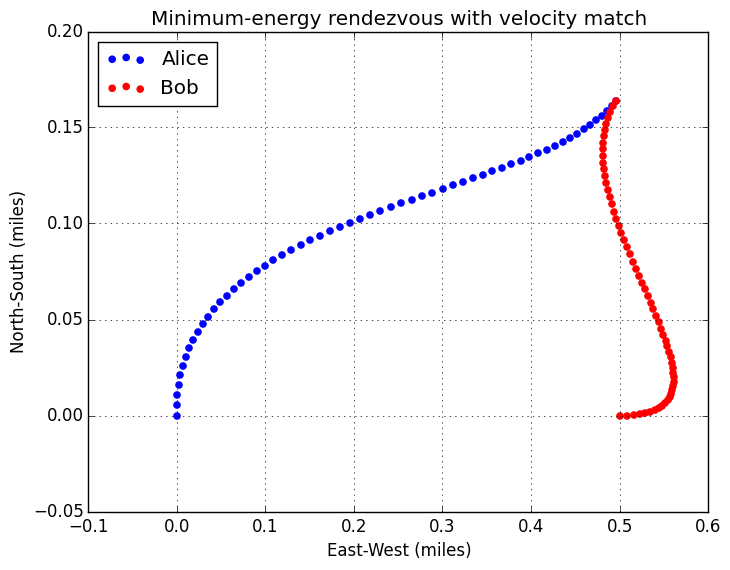

In [72]:
scatter(getvalue(A_x[1,:]), getvalue(A_x[2,:]),color = "blue", label = "Alice")
scatter(getvalue(B_x[1,:]), getvalue(B_x[2,:]),color = "red", label = "Bob")
xlabel("East-West (miles)")
ylabel("North-South (miles)")
legend(loc = "upper left")
grid()
title("Minimum-energy rendezvous with velocity match");

In [73]:
#PART C: Meet somewhere, match velocity, obey speed limit, and minimize energy

# speed constraint < 35mph
for i = 1:st
    @constraint(m, norm(A_v[:,i]) <= 35)
    @constraint(m, norm(B_v[:,i]) <= 35)
end

# Gurobi doesn't support quadratic objectives mixed with quadratic constraints. So let's improvise!
# Let's use the epigraph trick to turn the quadratic objective into a linear one.
# this turns the optimization problem into an SOCP.
# the alternative is to just use a nonlinear solver, but using a SOCP solver is faster and more accurate

@variable(m, t)
@constraint(m, norm([A_u B_u][:]) <= t)    # norm of the combined velocity vector from A and B.
@objective(m, Min, t)

solve(m)

println("The minimum energy is ", getobjectivevalue(m)^2)

The minimum energy is 238.10498020043528


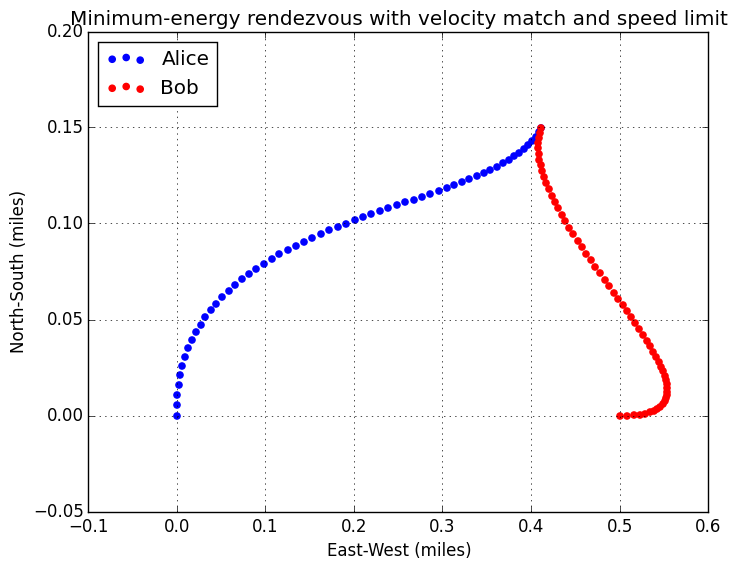

In [74]:
scatter(getvalue(A_x[1,:]), getvalue(A_x[2,:]),color = "blue", label = "Alice")
scatter(getvalue(B_x[1,:]), getvalue(B_x[2,:]),color = "red", label = "Bob")
xlabel("East-West (miles)")
ylabel("North-South (miles)")
legend(loc = "upper left")
grid()
title("Minimum-energy rendezvous with velocity match and speed limit");

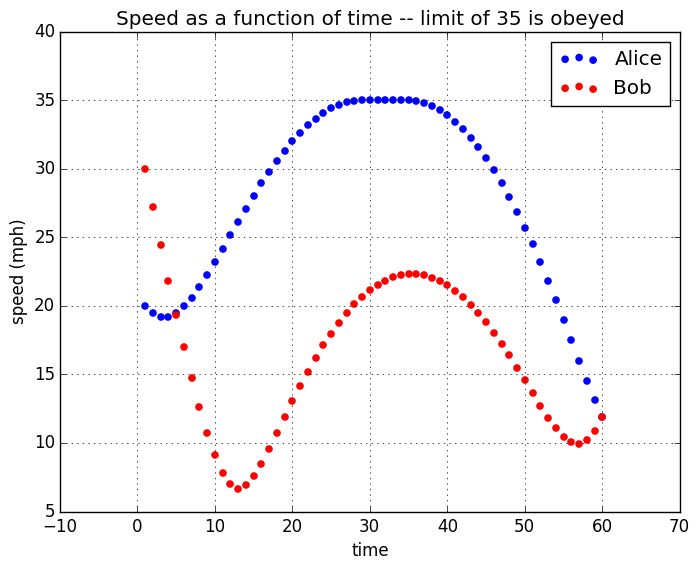

In [75]:
# plot speeds to make sure we respected the speed limit of 35

A_speed = sqrt( getvalue( A_v[1,:].^2 + A_v[2,:].^2 ) )'
B_speed = sqrt( getvalue( B_v[1,:].^2 + B_v[2,:].^2 ) )'

scatter(1:st, A_speed, color = "blue", label = "Alice")
scatter(1:st, B_speed, color = "red", label = "Bob")
legend(loc = "best")
xlabel("time")
ylabel("speed (mph)")
grid()
title("Speed as a function of time -- limit of 35 is obeyed");